In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from math import sqrt
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
done = pd.read_csv('Electric_Production.csv')
d1 = pd.DataFrame(done)
d1

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [3]:
#printing p-value and critical values
result = adfuller(d1['IPG2211A2N'].values)
print('ADF Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

#printing whether time-series is stationary or not
if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
   
else:
    print ("Time Series is Non-Stationary")

ADF Statistics:  -2.25699035004725
p-value:  0.18621469116586592
Critical Values:
1% -3.4476305904172904
5% -2.869155980820355
10% -2.570827146203181
Time Series is Non-Stationary


In [4]:
#kpss statistics
result = kpss(d1['IPG2211A2N'].values)
print('KPSS Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[3].items():
    print(key, value)

if result[0] > result[3]["5%"]:
    print ("Time Series is not Stationary")
else:
    print ("Time Series is Stationary")

KPSS Statistics:  3.5315970094994853
p-value:  0.01
Critical Values:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739
Time Series is not Stationary


C:\Users\bhart\AppData\Local\Temp\ipykernel_760\2161694552.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(d1['IPG2211A2N'].values)


In [5]:
#perioding
d1['diffe']= d1['IPG2211A2N'].diff(periods=1)
diff1 = d1['diffe'][1:]
diff1 = pd.DataFrame(diff1,columns=['diffe'])
diff1

,diffe
1,-1.8332
2,-8.2218
3,-4.9788
4,-2.1563
5,2.7753
...,...
392,-10.3158
393,-5.0017
394,3.7222
395,17.3853


In [6]:
#testing for stationarity
result = adfuller(diff1['diffe'].values)
print('ADF Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

if result[0] < result[4]["5%"]:
    print ("Time Series is Stationary")
   
else:
    print ("Time Series is Non-Stationary")

ADF Statistics:  -7.104890882267312
p-value:  4.0777865655394095e-10
Critical Values:
1% -3.4476305904172904
5% -2.869155980820355
10% -2.570827146203181
Time Series is Stationary


KPSS Statistics:  0.14518934657460816
p-value:  0.1
Critical Values:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739
Time Series is Stationary


C:\Users\bhart\AppData\Local\Temp\ipykernel_760\1158258516.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(diff1['diffe'].values)


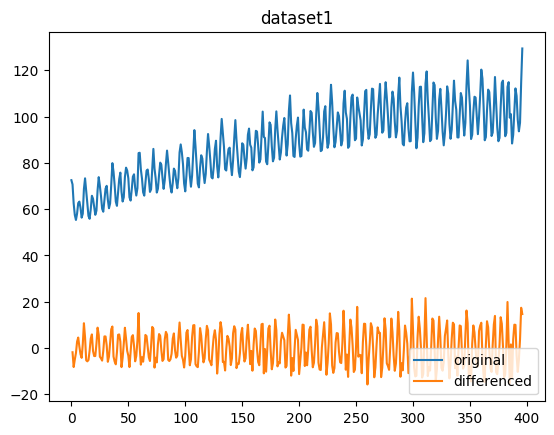

In [7]:
#visualizing the time-series dataset 
result = kpss(diff1['diffe'].values)
print('KPSS Statistics: ',result[0])
print('p-value: ', result[1])
print('Critical Values:')
for key, value in result[3].items():
    print(key, value)

if result[0] > result[3]["5%"]:
    print ("Time Series is not Stationary")
else:
    print ("Time Series is Stationary")

plt.title('dataset1')

plt.plot(d1['IPG2211A2N'])

plt.plot(diff1['diffe'])
plt.legend(["original", "differenced"], loc ="lower right") 

Viewing Auto-correlation and Partial Auto-correlation

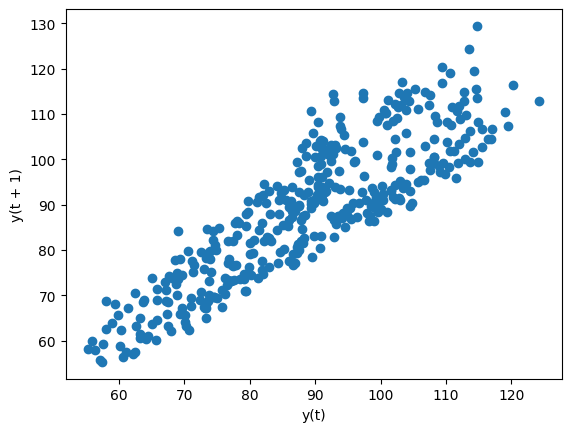

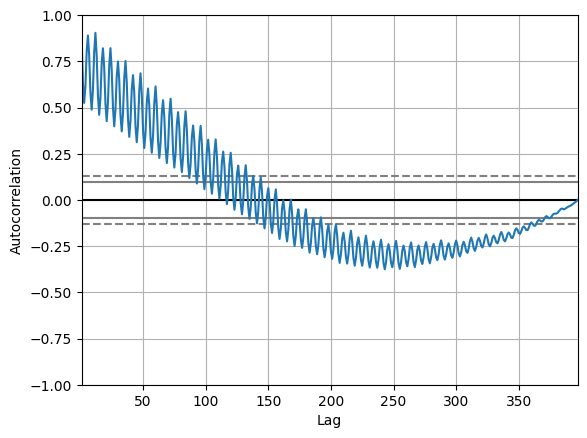

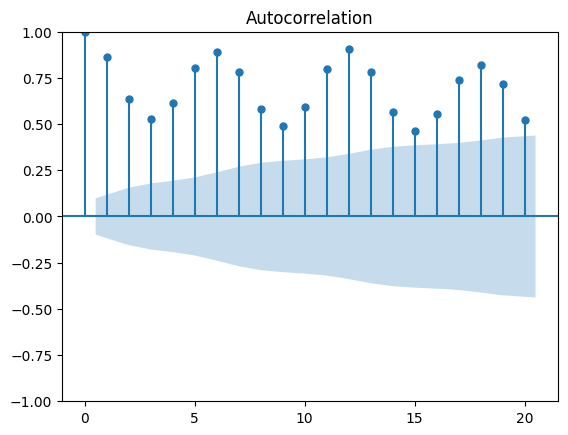

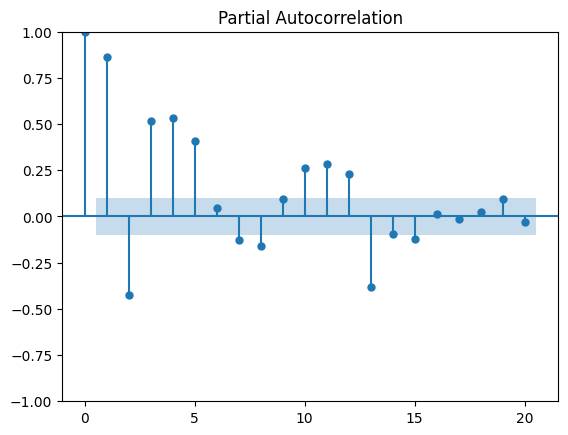

In [8]:

lag_plot(d1['IPG2211A2N'])
pyplot.show()
autocorrelation_plot(d1['IPG2211A2N'])
pyplot.show()
plot_acf(d1['IPG2211A2N'],lags = 20)
pyplot.show()
plot_pacf(d1['IPG2211A2N'],lags = 20)
pyplot.show()

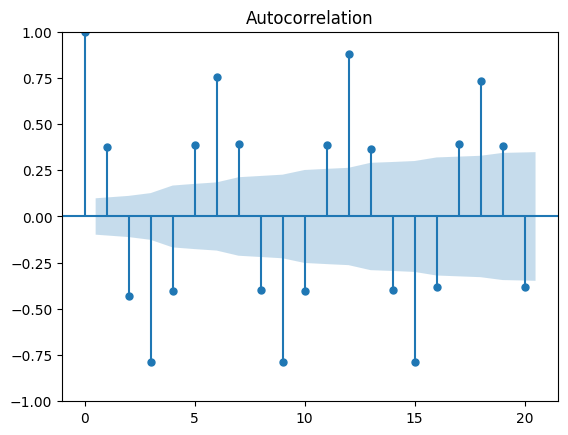

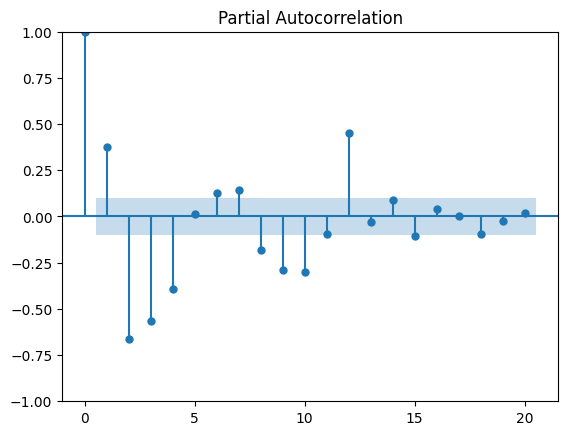

In [9]:
plot_acf(diff1['diffe'],lags=20)
pyplot.show()
plot_pacf(diff1['diffe'],lags = 20)
pyplot.show()

Modeling the Dataset

In [10]:
def eval_arima_model(dataset,order):
  
  train_size = int(len(dataset)*0.65)
  train,test = dataset[0:train_size],dataset[train_size:]
  history = [x for x in train]
  preds = []
  for b in range(len(test)):
    model = ARIMA(history,order = order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    preds.append(yhat)
    history.append(test[b])

  mse = mean_squared_error(test,preds)
  rmse = sqrt(mean_squared_error(test,preds))

  return mse,rmse

In [11]:
def eval_models(dataset,pvals,dvals,qvals):
  dataset = dataset.astype("float32")
  best_mse,best_rmse,best_params = float("inf"),float("inf"),None
  for p in pvals:
    for d in dvals:
      for q in qvals:
        order = (p,d,q)
        try:
          mse,rmse = eval_arima_model(dataset,order)
          if mse < best_mse:
            best_mse,best_params = mse,order
          if rmse < best_rmse:
            best_rmse = rmse
          print('ARIMA%s MSE=%.3f RMSE=%.3f' % (order,mse,rmse))
        except:
          continue
  #print('BEST ARIMA%s MSE=%.3f RMSE=%.3f' % (order,best_mse,best_rmse))

In [12]:
pvals = range(4,11)
dvals = range(0, 3)
qvals = range(4,11)
warnings.filterwarnings("ignore")
eval_models(diff1['diffe'].values, pvals, dvals,qvals)

ARIMA(4, 0, 4) MSE=14.314 RMSE=3.783
ARIMA(4, 0, 5) MSE=14.543 RMSE=3.814
ARIMA(4, 0, 6) MSE=15.237 RMSE=3.903
ARIMA(4, 0, 7) MSE=14.960 RMSE=3.868
ARIMA(4, 0, 8) MSE=15.013 RMSE=3.875
ARIMA(4, 0, 9) MSE=14.338 RMSE=3.787
ARIMA(4, 0, 10) MSE=13.619 RMSE=3.690
ARIMA(4, 1, 4) MSE=19.208 RMSE=4.383
ARIMA(4, 1, 5) MSE=14.465 RMSE=3.803
ARIMA(4, 1, 6) MSE=14.172 RMSE=3.765
ARIMA(4, 1, 7) MSE=13.420 RMSE=3.663
ARIMA(4, 1, 8) MSE=13.530 RMSE=3.678
ARIMA(4, 1, 9) MSE=13.882 RMSE=3.726
ARIMA(4, 1, 10) MSE=12.744 RMSE=3.570
ARIMA(4, 2, 4) MSE=22.788 RMSE=4.774
ARIMA(4, 2, 5) MSE=26.531 RMSE=5.151
ARIMA(4, 2, 6) MSE=17.201 RMSE=4.147
ARIMA(4, 2, 7) MSE=14.717 RMSE=3.836
ARIMA(4, 2, 8) MSE=15.449 RMSE=3.931
ARIMA(4, 2, 9) MSE=16.535 RMSE=4.066
ARIMA(4, 2, 10) MSE=16.125 RMSE=4.016
ARIMA(5, 0, 5) MSE=14.873 RMSE=3.857
ARIMA(5, 0, 6) MSE=13.819 RMSE=3.717
ARIMA(5, 0, 7) MSE=14.611 RMSE=3.822
ARIMA(5, 0, 8) MSE=13.803 RMSE=3.715
ARIMA(5, 0, 9) MSE=13.109 RMSE=3.621
ARIMA(5, 0, 10) MSE=13.555 RMSE=3.6

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(d1['IPG2211A2N'], model='additive', period=12)

<Figure size 640x480 with 0 Axes>

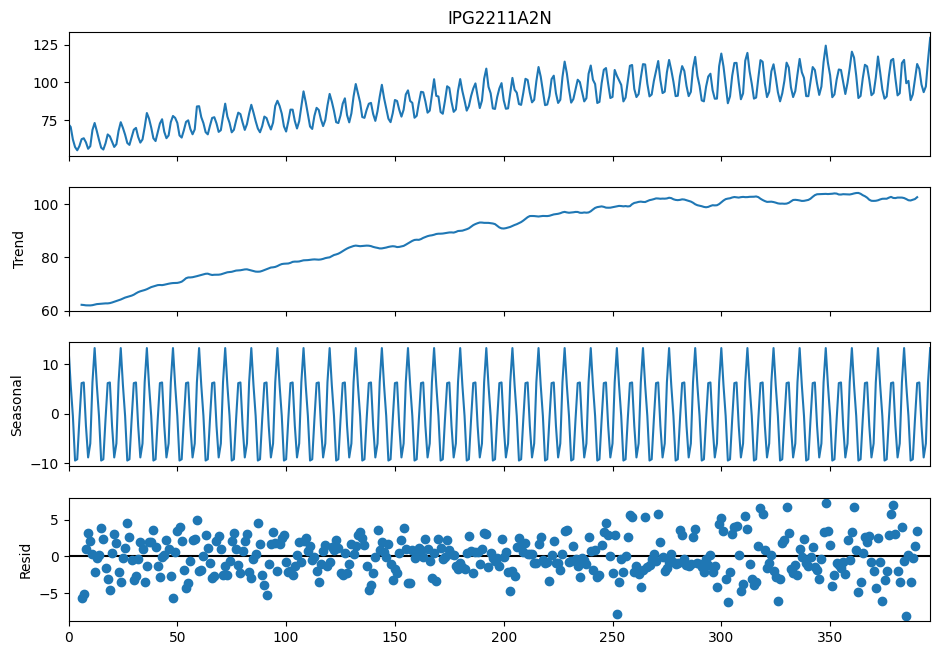

In [16]:
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10,7)

In [45]:
X = diff1['diffe'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []

In [46]:
for t in range(len(test)):
	model = ARIMA(history, order=(8,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)


Test MSE: 18.601
Test RMSE: 4.313
Test R2SCORE: 0.791


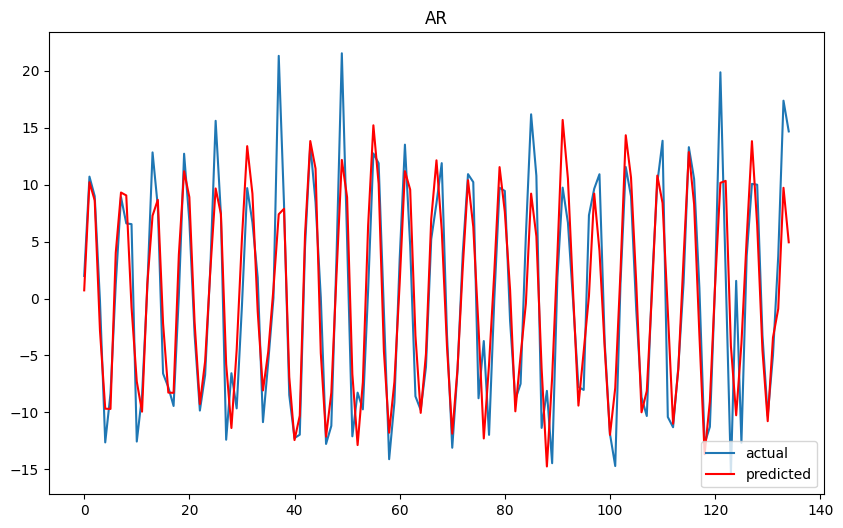

In [47]:
rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')
ax.legend(loc='lower right')
plt.title('AR')

pyplot.show()

In [48]:
X = diff1['diffe'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []
for t in range(len(test)):
	model = ARIMA(history, order=(0,0,8))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)

In [49]:
rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)


Test MSE: 28.499
Test RMSE: 5.338
Test R2SCORE: 0.679


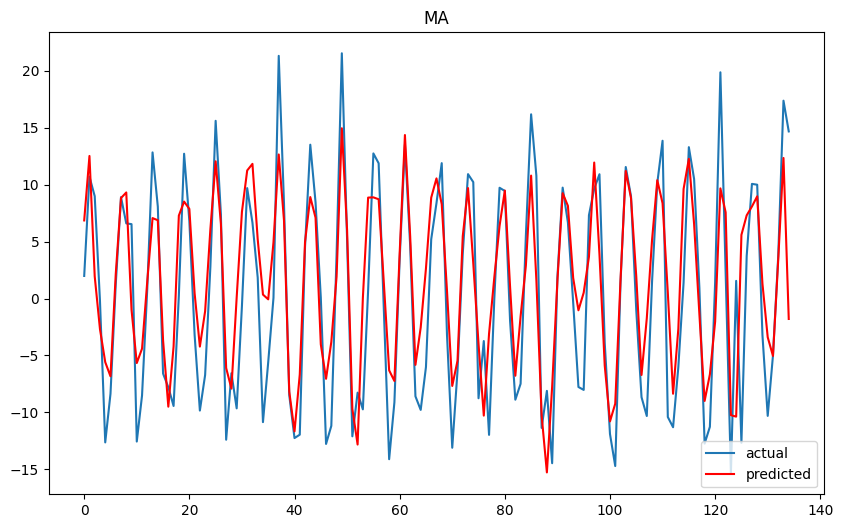

In [51]:
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')
ax.legend(loc='lower right')
plt.title('MA')

pyplot.show()

In [52]:
X = diff1['diffe'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []
for t in range(len(test)):
	model = ARIMA(history, order=(8,0,8))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)


In [53]:
rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)


Test MSE: 11.104
Test RMSE: 3.332
Test R2SCORE: 0.875


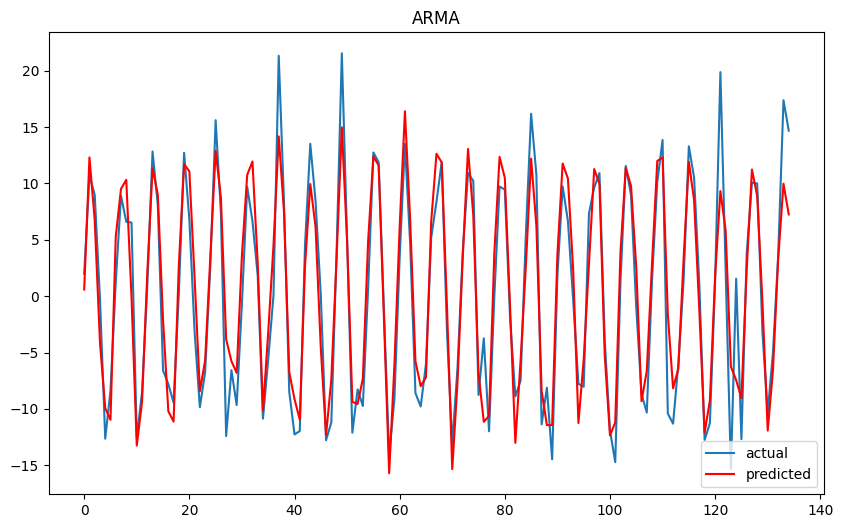

In [54]:
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')
ax.legend(loc='lower right')
plt.title('ARMA')

pyplot.show()

In [55]:
X = diff1['diffe'].values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
preds = []
for t in range(len(test)):
	model = ARIMA(history, order=(8,0,8))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	preds.append(yhat)
	obs = test[t]
	history.append(obs)

Test MSE: 11.104
Test RMSE: 3.332
Test R2SCORE: 0.875


Text(0.5, 1.0, 'ARIMA')

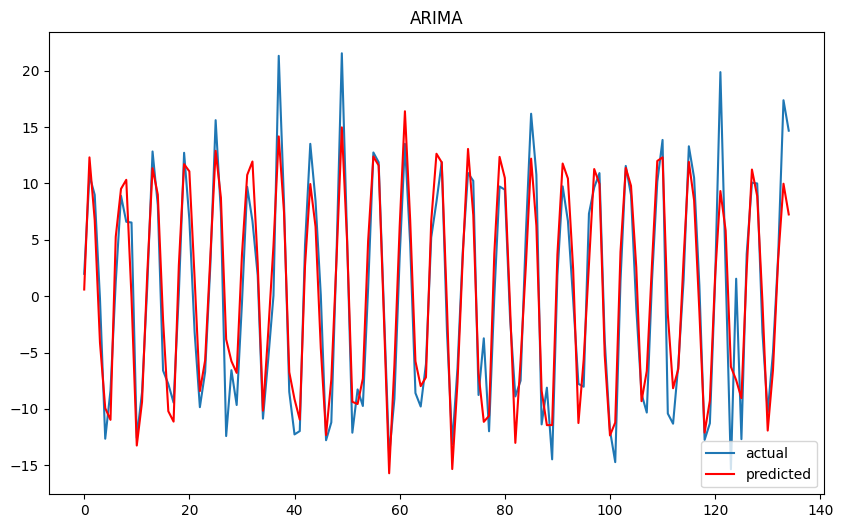

In [56]:
rmse = sqrt(mean_squared_error(test, preds))
mse = mean_squared_error(test,preds)
r2score = r2_score(test,preds)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test R2SCORE: %.3f' % r2score)

fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
pyplot.plot(test,label = 'actual')
pyplot.plot(preds, color='red',label = 'predicted')
ax.legend(loc='lower right')
plt.title('ARIMA')

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
best_model = SARIMAX(d1['IPG2211A2N'], order=(8,0,8), seasonal_order=(1, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              IPG2211A2N   No. Observations:                  397
Model:             SARIMAX(8, 0, 8)x(1, 1, [1, 2], 12)   Log Likelihood                -880.500
Date:                                 Mon, 29 Jul 2024   AIC                           1801.000
Time:                                         07:46:28   BIC                           1880.064
Sample:                                              0   HQIC                          1832.357
                                                 - 397                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4591      0.157      2.919      0.004       0.151       0

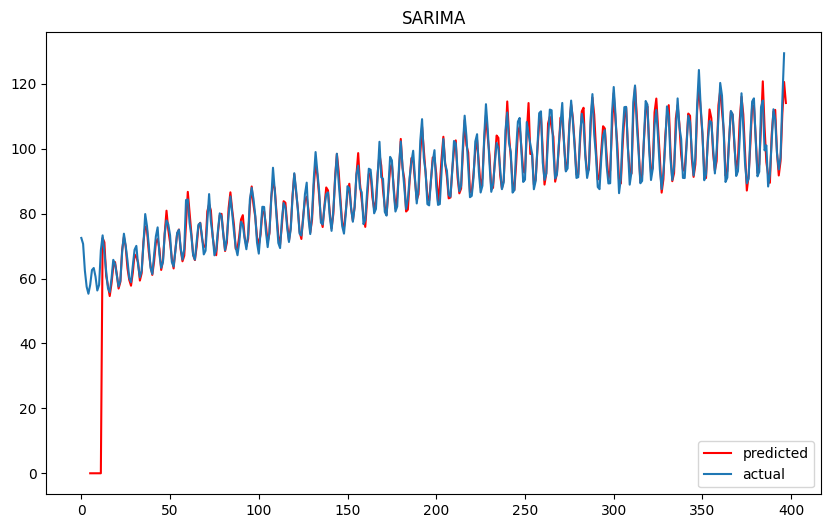

In [58]:
d1['sarima_model'] = best_model.fittedvalues
d1['sarima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=d1.shape[0], end=d1.shape[0])
forecast = d1['sarima_model']._append(forecast)
fig = plt.figure(figsize=(10, 6))
ax = fig.subplots()
plt.plot(forecast, color='r', label='predicted')
plt.plot(d1['IPG2211A2N'], label='actual')
ax.legend(loc='lower right')
plt.title('SARIMA')
plt.show()